In [1]:
import torch
import torchvision
import torchvision.transforms as transforms

device = torch.accelerator.current_accelerator() if torch.accelerator.is_available() else "cpu"

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 4

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')





torch.Size([4, 3, 32, 32])


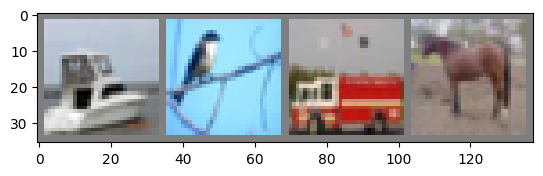

ship  bird  truck horse


In [2]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    #This reorders the dimensions from (C, H, W) - PyTorch's channel-first format - to (H, W, C) which matplotlib's `imshow()` expects.
    # Move the first column to last

    plt.imshow(np.transpose(npimg, (1, 2, 0)))

    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

# Confirm : batch size = 4, channel = 3,  image size 32 * 32
print(images.shape)

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))


In [3]:
import torch.nn as nn
import torch.nn.functional as F


class Classifier(nn.Module):
    def __init__(self):
        super().__init__()
        # input channel, output channel (num of filter), kernel size
        # 4, 3 32 32
        # I + 2p - k = 32 + 2*0 - 5 = 27   27/stride + 1 = 28
        self.conv1 = nn.Conv2d(3, 6, 5)
        # 6, 28, 28 
        self.pool = nn.MaxPool2d(2, 2)
        # 6, 14, 14 
        # I + 2P - k = 14 + 2*0 - 5 = 9
        # 9/stride + 1 = 10
        # output 16, 10, 10
        # pool again :  16, 5, 5
        self.conv2 = nn.Conv2d(6, 16, 5)

        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)


    def forward(self, x):

        c1 = F.relu(self.conv1(x))
        s2 = self.pool(c1)
        c3 = F.relu(self.conv2(s2))
        s4 = self.pool(c3)
        s4 = torch.flatten(s4, 1)
        f5 = F.relu(self.fc1(s4))
        f6 = F.relu(self.fc2(f5))
        f7 = self.fc3(f6)

        output = f7

        return output


net = Classifier()
net.to(device)



Classifier(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

> Momentum Insight:
> Momentum helps in smoothing out the updates, especially in scenarios where the
> gradient direction keeps changing (e.g., ravines or valleys in the loss
> surface). A momentum of 0.9 means that 90% of the previous gradient update is
> retained and combined with the current one.





In [4]:

import torch.optim as optim

loss_fn = nn.CrossEntropyLoss()

optimizer = optim.SGD(net.parameters(), lr = 0.001, momentum = 0.9)



for epoch in range(2):
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        inputs, lables = data
        inputs, lables = inputs.to(device), lables.to(device)
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = loss_fn(outputs, lables)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
            running_loss = 0.0

print('Finished Training')



PATH = "./Classifer_net.pth"
torch.save(net.state_dict(), PATH)



[1,  2000] loss: 2.190


[1,  4000] loss: 1.761


[1,  6000] loss: 1.653


[1,  8000] loss: 1.590


[1, 10000] loss: 1.518


[1, 12000] loss: 1.446


[2,  2000] loss: 1.405


[2,  4000] loss: 1.358


[2,  6000] loss: 1.341


[2,  8000] loss: 1.333


[2, 10000] loss: 1.321


[2, 12000] loss: 1.275


Finished Training


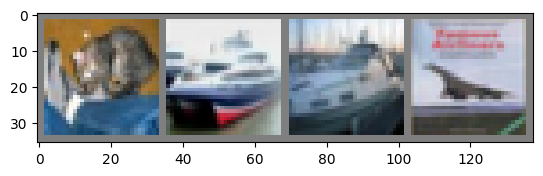

GroundTruth:  cat   ship  ship  plane


In [5]:
dataiter = iter(testloader)
images, labels = next(dataiter)

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join(f'{classes[labels[j]]:5s}' for j in range(4)))


In [7]:

load_net = Classifier()
load_net.load_state_dict(torch.load(PATH, weights_only=True))


outputs = load_net(images)


_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join(f'{classes[predicted[j]]:5s}'
                              for j in range(4)))



Predicted:  cat   ship  ship  plane


Predicted:  cat   ship  ship  plane


In [17]:

tensor_test = torch.rand(3,4,5,6)

#print(tensor_test)

print(tensor_test.shape)

print(tensor_test.size())
print(tensor_test.size(0))
print(tensor_test.size(1))
print(tensor_test.size(2))
print(tensor_test.size(3))


torch.Size([3, 4, 5, 6])
torch.Size([3, 4, 5, 6])
3
4
5
6


In [18]:

correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in testloader:
        images, labels = data
        # calculate outputs by running images through the network
        outputs = load_net(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs, 1)
        # number of samples in the batch
        # Returns the size of the `self` tensor. If `dim` is not specified, 
        # the returned value is a `torch.Size`, a subclass of `tuple`.
        # If `dim` is specified, returns an int holding the size of that dimension.

        #print(f"labels: \n { labels.shape } \n")
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the 10000 test images: {100 * correct // total} %')




labels: 
 torch.Size([4]) 

labels: 
 torch.Size([4]) 

labels: 
 torch.Size([4]) 

labels: 
 torch.Size([4]) 

labels: 
 torch.Size([4]) 

labels: 
 torch.Size([4]) 

labels: 
 torch.Size([4]) 

labels: 
 torch.Size([4]) 

labels: 
 torch.Size([4]) 

labels: 
 torch.Size([4]) 

labels: 
 torch.Size([4]) 

labels: 
 torch.Size([4]) 

labels: 
 torch.Size([4]) 

labels: 
 torch.Size([4]) 

labels: 
 torch.Size([4]) 

labels: 
 torch.Size([4]) 

labels: 
 torch.Size([4]) 

labels: 
 torch.Size([4]) 

labels: 
 torch.Size([4]) 

labels: 
 torch.Size([4]) 

labels: 
 torch.Size([4]) 

labels: 
 torch.Size([4]) 

labels: 
 torch.Size([4]) 

labels: 
 torch.Size([4]) 

labels: 
 torch.Size([4]) 

labels: 
 torch.Size([4]) 

labels: 
 torch.Size([4]) 

labels: 
 torch.Size([4]) 

labels: 
 torch.Size([4]) 

labels: 
 torch.Size([4]) 

labels: 
 torch.Size([4]) 

labels: 
 torch.Size([4]) 

labels: 
 torch.Size([4]) 

labels: 
 torch.Size([4]) 

labels: 
 torch.Size([4]) 

labels: 
 torch.Size

labels: 
 torch.Size([4]) 

labels: 
 torch.Size([4]) 

labels: 
 torch.Size([4]) 

labels: 
 torch.Size([4]) 

labels: 
 torch.Size([4]) 

labels: 
 torch.Size([4]) 

labels: 
 torch.Size([4]) 

labels: 
 torch.Size([4]) 

labels: 
 torch.Size([4]) 

labels: 
 torch.Size([4]) 

labels: 
 torch.Size([4]) 

labels: 
 torch.Size([4]) 

labels: 
 torch.Size([4]) 

labels: 
 torch.Size([4]) 

labels: 
 torch.Size([4]) 

labels: 
 torch.Size([4]) 

labels: 
 torch.Size([4]) 

labels: 
 torch.Size([4]) 

labels: 
 torch.Size([4]) 

labels: 
 torch.Size([4]) 

labels: 
 torch.Size([4]) 

labels: 
 torch.Size([4]) 

labels: 
 torch.Size([4]) 

labels: 
 torch.Size([4]) 

labels: 
 torch.Size([4]) 

labels: 
 torch.Size([4]) 

labels: 
 torch.Size([4]) 

labels: 
 torch.Size([4]) 

labels: 
 torch.Size([4]) 

labels: 
 torch.Size([4]) 

labels: 
 torch.Size([4]) 

labels: 
 torch.Size([4]) 

labels: 
 torch.Size([4]) 

labels: 
 torch.Size([4]) 

labels: 
 torch.Size([4]) 

labels: 
 torch.Size

labels: 
 torch.Size([4]) 

labels: 
 torch.Size([4]) 

labels: 
 torch.Size([4]) 

labels: 
 torch.Size([4]) 

labels: 
 torch.Size([4]) 

labels: 
 torch.Size([4]) 

labels: 
 torch.Size([4]) 

labels: 
 torch.Size([4]) 

labels: 
 torch.Size([4]) 

labels: 
 torch.Size([4]) 

labels: 
 torch.Size([4]) 

labels: 
 torch.Size([4]) 

labels: 
 torch.Size([4]) 

labels: 
 torch.Size([4]) 

labels: 
 torch.Size([4]) 

labels: 
 torch.Size([4]) 

labels: 
 torch.Size([4]) 

labels: 
 torch.Size([4]) 

labels: 
 torch.Size([4]) 

labels: 
 torch.Size([4]) 

labels: 
 torch.Size([4]) 

labels: 
 torch.Size([4]) 

labels: 
 torch.Size([4]) 

labels: 
 torch.Size([4]) 

labels: 
 torch.Size([4]) 

labels: 
 torch.Size([4]) 

labels: 
 torch.Size([4]) 

labels: 
 torch.Size([4]) 

labels: 
 torch.Size([4]) 

labels: 
 torch.Size([4]) 

labels: 
 torch.Size([4]) 

labels: 
 torch.Size([4]) 

labels: 
 torch.Size([4]) 

labels: 
 torch.Size([4]) 

labels: 
 torch.Size([4]) 

labels: 
 torch.Size

labels: 
 torch.Size([4]) 

labels: 
 torch.Size([4]) 

labels: 
 torch.Size([4]) 

labels: 
 torch.Size([4]) 

labels: 
 torch.Size([4]) 

labels: 
 torch.Size([4]) 

labels: 
 torch.Size([4]) 

labels: 
 torch.Size([4]) 

labels: 
 torch.Size([4]) 

labels: 
 torch.Size([4]) 

labels: 
 torch.Size([4]) 

labels: 
 torch.Size([4]) 

labels: 
 torch.Size([4]) 

labels: 
 torch.Size([4]) 

labels: 
 torch.Size([4]) 

labels: 
 torch.Size([4]) 

labels: 
 torch.Size([4]) 

labels: 
 torch.Size([4]) 

labels: 
 torch.Size([4]) 

labels: 
 torch.Size([4]) 

labels: 
 torch.Size([4]) 

labels: 
 torch.Size([4]) 

labels: 
 torch.Size([4]) 

labels: 
 torch.Size([4]) 

labels: 
 torch.Size([4]) 

labels: 
 torch.Size([4]) 

labels: 
 torch.Size([4]) 

labels: 
 torch.Size([4]) 

labels: 
 torch.Size([4]) 

labels: 
 torch.Size([4]) 

labels: 
 torch.Size([4]) 

labels: 
 torch.Size([4]) 

labels: 
 torch.Size([4]) 

labels: 
 torch.Size([4]) 

labels: 
 torch.Size([4]) 

labels: 
 torch.Size

labels: 
 torch.Size([4]) 

labels: 
 torch.Size([4]) 

labels: 
 torch.Size([4]) 

labels: 
 torch.Size([4]) 

labels: 
 torch.Size([4]) 

labels: 
 torch.Size([4]) 

labels: 
 torch.Size([4]) 

labels: 
 torch.Size([4]) 

labels: 
 torch.Size([4]) 

labels: 
 torch.Size([4]) 

labels: 
 torch.Size([4]) 

labels: 
 torch.Size([4]) 

labels: 
 torch.Size([4]) 

labels: 
 torch.Size([4]) 

labels: 
 torch.Size([4]) 

labels: 
 torch.Size([4]) 

labels: 
 torch.Size([4]) 

labels: 
 torch.Size([4]) 

labels: 
 torch.Size([4]) 

labels: 
 torch.Size([4]) 

labels: 
 torch.Size([4]) 

labels: 
 torch.Size([4]) 

labels: 
 torch.Size([4]) 

labels: 
 torch.Size([4]) 

labels: 
 torch.Size([4]) 

labels: 
 torch.Size([4]) 

labels: 
 torch.Size([4]) 

labels: 
 torch.Size([4]) 

labels: 
 torch.Size([4]) 

labels: 
 torch.Size([4]) 

labels: 
 torch.Size([4]) 

labels: 
 torch.Size([4]) 

labels: 
 torch.Size([4]) 

labels: 
 torch.Size([4]) 

labels: 
 torch.Size([4]) 

labels: 
 torch.Size

labels: 
 torch.Size([4]) 

labels: 
 torch.Size([4]) 

labels: 
 torch.Size([4]) 

labels: 
 torch.Size([4]) 

labels: 
 torch.Size([4]) 

labels: 
 torch.Size([4]) 

labels: 
 torch.Size([4]) 

labels: 
 torch.Size([4]) 

labels: 
 torch.Size([4]) 

labels: 
 torch.Size([4]) 

labels: 
 torch.Size([4]) 

labels: 
 torch.Size([4]) 

labels: 
 torch.Size([4]) 

labels: 
 torch.Size([4]) 

labels: 
 torch.Size([4]) 

labels: 
 torch.Size([4]) 

labels: 
 torch.Size([4]) 

labels: 
 torch.Size([4]) 

labels: 
 torch.Size([4]) 

labels: 
 torch.Size([4]) 

labels: 
 torch.Size([4]) 

labels: 
 torch.Size([4]) 

labels: 
 torch.Size([4]) 

labels: 
 torch.Size([4]) 

labels: 
 torch.Size([4]) 

labels: 
 torch.Size([4]) 

labels: 
 torch.Size([4]) 

labels: 
 torch.Size([4]) 

labels: 
 torch.Size([4]) 

labels: 
 torch.Size([4]) 

labels: 
 torch.Size([4]) 

labels: 
 torch.Size([4]) 

labels: 
 torch.Size([4]) 

labels: 
 torch.Size([4]) 

labels: 
 torch.Size([4]) 

labels: 
 torch.Size

labels: 
 torch.Size([4]) 

labels: 
 torch.Size([4]) 

labels: 
 torch.Size([4]) 

labels: 
 torch.Size([4]) 

labels: 
 torch.Size([4]) 

labels: 
 torch.Size([4]) 

labels: 
 torch.Size([4]) 

labels: 
 torch.Size([4]) 

labels: 
 torch.Size([4]) 

labels: 
 torch.Size([4]) 

labels: 
 torch.Size([4]) 

labels: 
 torch.Size([4]) 

labels: 
 torch.Size([4]) 

labels: 
 torch.Size([4]) 

labels: 
 torch.Size([4]) 

labels: 
 torch.Size([4]) 

labels: 
 torch.Size([4]) 

labels: 
 torch.Size([4]) 

labels: 
 torch.Size([4]) 

labels: 
 torch.Size([4]) 

labels: 
 torch.Size([4]) 

labels: 
 torch.Size([4]) 

labels: 
 torch.Size([4]) 

labels: 
 torch.Size([4]) 

labels: 
 torch.Size([4]) 

labels: 
 torch.Size([4]) 

labels: 
 torch.Size([4]) 

labels: 
 torch.Size([4]) 

labels: 
 torch.Size([4]) 

labels: 
 torch.Size([4]) 

labels: 
 torch.Size([4]) 

labels: 
 torch.Size([4]) 

labels: 
 torch.Size([4]) 

labels: 
 torch.Size([4]) 

labels: 
 torch.Size([4]) 

labels: 
 torch.Size

labels: 
 torch.Size([4]) 

labels: 
 torch.Size([4]) 

labels: 
 torch.Size([4]) 

labels: 
 torch.Size([4]) 

labels: 
 torch.Size([4]) 

labels: 
 torch.Size([4]) 

labels: 
 torch.Size([4]) 

labels: 
 torch.Size([4]) 

labels: 
 torch.Size([4]) 

labels: 
 torch.Size([4]) 

labels: 
 torch.Size([4]) 

labels: 
 torch.Size([4]) 

labels: 
 torch.Size([4]) 

labels: 
 torch.Size([4]) 

labels: 
 torch.Size([4]) 

labels: 
 torch.Size([4]) 

labels: 
 torch.Size([4]) 

labels: 
 torch.Size([4]) 

labels: 
 torch.Size([4]) 

labels: 
 torch.Size([4]) 

labels: 
 torch.Size([4]) 

labels: 
 torch.Size([4]) 

labels: 
 torch.Size([4]) 

labels: 
 torch.Size([4]) 

labels: 
 torch.Size([4]) 

labels: 
 torch.Size([4]) 

labels: 
 torch.Size([4]) 

labels: 
 torch.Size([4]) 

labels: 
 torch.Size([4]) 

labels: 
 torch.Size([4]) 

labels: 
 torch.Size([4]) 

labels: 
 torch.Size([4]) 

labels: 
 torch.Size([4]) 

labels: 
 torch.Size([4]) 

labels: 
 torch.Size([4]) 

labels: 
 torch.Size